<a href="https://colab.research.google.com/github/muhalisra/muhalisra/blob/main/Salinan_Projek_kantuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

!python -m venv venv

!pip install torch torchvision opencv-python mediapipe numpy playsound

Error: Command '['/content/venv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.


In [ ]:
# file: drowsiness_yolov11_ear.py
import cv2
import time
import numpy as np
import mediapipe as mp
from math import hypot
from playsound import playsound
import threading


EAR_THRESHOLD = 0.25
CONSEC_FRAMES = 5
ALARM_SOUND_PATH = "alarm.wav"  # siapkan file alarm.wav di folder proyek
YOLO_WEIGHTS_PATH = "yolov11_face.pt"  # ganti sesuai file Anda
OUTPUT_VIDEO_PATH = "output_drowsiness.mp4" # path untuk menyimpan video hasil


def euclidean(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

def compute_ear(eye_landmarks):
    # eye_landmarks: list of 6 (x,y) points in order [p1..p6]
    A = euclidean(eye_landmarks[1], eye_landmarks[5])
    B = euclidean(eye_landmarks[2], eye_landmarks[4])
    C = euclidean(eye_landmarks[0], eye_landmarks[3])
    if C == 0:
        return 0.0
    ear = (A + B) / (2.0 * C)
    return ear

# --- Mediapipe Face Mesh init ---
mp_face = mp.solutions.face_mesh
face_mesh = mp_face.FaceMesh(static_image_mode=False,
                             max_num_faces=1,
                             refine_landmarks=True,
                             min_detection_confidence=0.5,
                             min_tracking_confidence=0.5)

import torch

def yolov11_infer(frame):
    """
    Return list of boxes: [(x1,y1,x2,y2,score), ...] in pixel coords.
    Replace this with your YOLOv11 inference code.
    """
    # For demo, return empty. Replace in your deployment.
    return []

# --- Alarm player in separate thread (non-blocking) ---
def play_alarm():
    try:
        playsound(ALARM_SOUND_PATH)
    except:
        pass

# --- Main loop ---
def main(video_path=None):
    if video_path:
        cap = cv2.VideoCapture(video_path)
    else:
        cap = cv2.VideoCapture(0)  # default to webcam if no video path is provided

    if not cap.isOpened():
        print(f"Error: Could not open video source {'webcam' if not video_path else video_path}")
        return

    # Get video properties for VideoWriter
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object
    # Use XVID for wider compatibility, or MP4V, H264, etc.
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for .mp4 files
    out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (frame_width, frame_height))

    frame_counter = 0
    alarm_on = False
    last_sound_time = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        h, w = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # 1) YOLOv11 face detection on full frame (replace with actual model)
        faces = yolov11_infer(frame)  # [(x1,y1,x2,y2,score), ...]

        # If faces empty, optionally run mediapipe face detection on whole frame
        if len(faces) == 0:
            # fallback: Mediapipe can detect face even without YOLO
            mp_results = face_mesh.process(rgb)
            if mp_results.multi_face_landmarks:
                for face_landmarks in mp_results.multi_face_landmarks:
                    # compute bounding box from landmarks
                    xs = [lm.x * w for lm in face_landmarks.landmark]
                    ys = [lm.y * h for lm in face_landmarks.landmark]
                    x1, x2 = int(min(xs)), int(max(xs))
                    y1, y2 = int(min(ys)), int(max(ys))
                    faces = [(x1,y1,x2,y2,0.9)]
                    break

        # Process first detected face (if multiple, you can iterate)
        if len(faces) > 0:
            x1,y1,x2,y2,score = faces[0]
            # ensure integers & in range
            x1,y1,x2,y2 = max(0,int(x1)), max(0,int(y1)), min(w,int(x2)), min(h,int(y2))

            results = face_mesh.process(rgb)
            if results.multi_face_landmarks:
                face_landmarks = results.multi_face_landmarks[0]

                LEFT_EYE_IDX = [33, 160, 158, 133, 153, 144]   # typical index set
                RIGHT_EYE_IDX = [362, 385, 387, 263, 373, 380] # typical index set

                def get_eye_coords(indices):
                    pts = []
                    for idx in indices:
                        lm = face_landmarks.landmark[idx]
                        pts.append((int(lm.x * w), int(lm.y * h)))
                    return pts

                left_eye = get_eye_coords(LEFT_EYE_IDX)
                right_eye = get_eye_coords(RIGHT_EYE_IDX)

                left_ear = compute_ear(left_eye)
                right_ear = compute_ear(right_eye)
                ear = (left_ear + right_ear) / 2.0

                # draw
                for (x,y) in left_eye:
                    cv2.circle(frame, (x,y), 2, (0,255,0), -1)
                for (x,y) in right_eye:
                    cv2.circle(frame, (x,y), 2, (0,255,0), -1)

                cv2.rectangle(frame, (x1,y1), (x2,y2), (255,0,0), 2)
                cv2.putText(frame, f"EAR:{ear:.3f}", (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)

                # drowsiness logic
                if ear < EAR_THRESHOLD:
                    frame_counter += 1
                    if frame_counter >= CONSEC_FRAMES:
                        cv2.putText(frame, "DROWSY!", (50, 50),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,255), 4)
                        # start alarm if not already
                        now = time.time()
                        if not alarm_on or (now - last_sound_time) > 5:
                            alarm_on = True
                            last_sound_time = now
                            threading.Thread(target=play_alarm, daemon=True).start()
                else:
                    frame_counter = 0
                    alarm_on = False

        out.write(frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

    cap.release()
    out.release() # Release the VideoWriter
    cv2.destroyAllWindows()
    print(f"Processed video saved to {OUTPUT_VIDEO_PATH}") # Confirmation message

if __name__ == "__main__":
    main()

Error: Could not open video source webcam


Untuk menjalankan skrip ini di lingkungan lokal Anda, ikuti langkah-langkah berikut:

### 1. Simpan Kode
Salin seluruh kode dari sel `drowsiness_yolov11_ear.py` ke dalam sebuah file baru bernama `drowsiness_detection.py` di komputer lokal Anda.

### 2. Siapkan File Sumber Daya
*   **`alarm.wav`**: Pastikan Anda memiliki file suara alarm bernama `alarm.wav` di direktori yang sama dengan skrip `drowsiness_detection.py` Anda. Anda dapat mengunduh atau membuat file `.wav` sendiri.
*   **`yolov11_face.pt`**: File model YOLOv11 (`yolov11_face.pt`) harus berada di direktori yang sama. Perhatikan bahwa fungsi `yolov11_infer` dalam kode saat ini adalah placeholder (`return []`). Anda perlu mengintegrasikan model YOLOv11 Anda yang sebenarnya di sini agar deteksi wajah bekerja dengan benar menggunakan YOLO.

### 3. Instal Dependensi
Buka terminal atau command prompt dan instal pustaka Python yang diperlukan:
```bash
pip install opencv-python mediapipe numpy playsound torch torchvision
```

### 4. Jalankan Skrip
Anda dapat menjalankan skrip dengan salah satu cara berikut:

#### a) Menggunakan Webcam Anda (Default)
Jika Anda ingin menggunakan webcam Anda untuk deteksi kantuk secara real-time, jalankan skrip tanpa argumen:
```bash
python drowsiness_detection.py
```

#### b) Menggunakan File Video
Jika Anda ingin menganalisis file video yang sudah ada, berikan jalur ke file video Anda sebagai argumen. Ganti `'path/to/your/video.mp4'` dengan jalur sebenarnya ke file video Anda:
```bash
python drowsiness_detection.py --video 'path/to/your/video.mp4'
```

Untuk membuat argumen command-line bekerja, Anda perlu sedikit memodifikasi skrip `drowsiness_detection.py` Anda. Tambahkan kode berikut di bawah `if __name__ == "__main__":` block untuk memparsing argumen:

```python
import argparse

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Drowsiness Detection System.")
    parser.add_argument('--video', type=str, help='Path to an optional video file to process instead of webcam.')
    args = parser.parse_args()

    main(video_path=args.video)
```

Setelah modifikasi ini, Anda dapat menjalankan skrip dengan argumen `--video` untuk file video.

In [ ]:

video_file_path = 'your_video_file.mp4' # Ganti dengan nama file video Anda
main(video_path=video_file_path)


Error: Could not open video source your_video_file.mp4


<IPython.core.display.Javascript object>

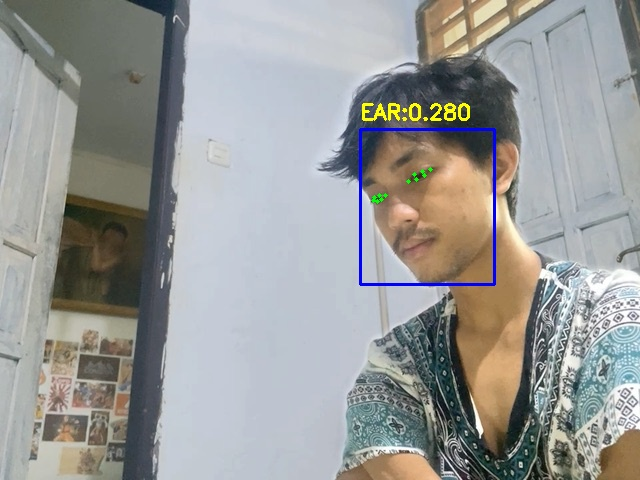

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Webcam stream stopped by user.
Webcam cleanup complete.


In [ ]:
live_webcam_drowsiness_detection()

In [ ]:
from playsound import playsound
import os

alarm_path = 'alarm.wav' # Pastikan path ini benar

if os.path.exists(alarm_path):
    print(f"Memutar alarm dari: {alarm_path}")
    try:
        playsound(alarm_path)
        print("Alarm berhasil diputar.")
    except Exception as e:
        print(f"Gagal memutar alarm: {e}")
else:
    print(f"File alarm tidak ditemukan di: {alarm_path}")


Memutar alarm dari: alarm.wav
Gagal memutar alarm: Command '['/usr/bin/python3', '/usr/local/lib/python3.12/dist-packages/playsound.py', 'alarm.wav']' returned non-zero exit status 1.
